## Bayesian Linear Regression

- <i>Pattern Recognition and Machine Learning</i> by Bishop (2006)
    - [Section 3.3 -  Bayesian Linear Regression](#)   

In [25]:
# %load std_ipython_import.txt
import pandas as pd
import scipy.stats as stats
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import pymc3 as pmc

pd.set_option('display.notebook_repr_html', False)

%matplotlib inline
%config InlineBackend.figure_formats = {'retina',}
plt.style.use('seaborn-white')

### Generate data

- Consider single input variable $x$ and output variable $t$ and model: $y(x,\textbf{w}) = w_0 + w_1x$


- Select $x_n$ from the uniform distribution where $x_n$ between -1 and 1.


- Create data using the function:<BR>
$f(x,a) = a_0 + a_1x$<BR>
where<BR>
$a_0 = -0.3$ and $a_1 = 0.5$



- Add Gaussian noise with standard deviation 0.2 to obtain target values $t_n$.

In [26]:
# Constants
size = 50
a = [-0.3, 0.5]
sd = .2

# grid for plotting
step = 100
xx, yy = np.meshgrid(np.linspace(-1,1,step), np.linspace(-1,1,step))
grid = np.c_[xx.ravel(), yy.ravel()]

x_ = np.linspace(-1,1,step).reshape(-1,1)

alpha = 2.
beta = 1./(sd**2)

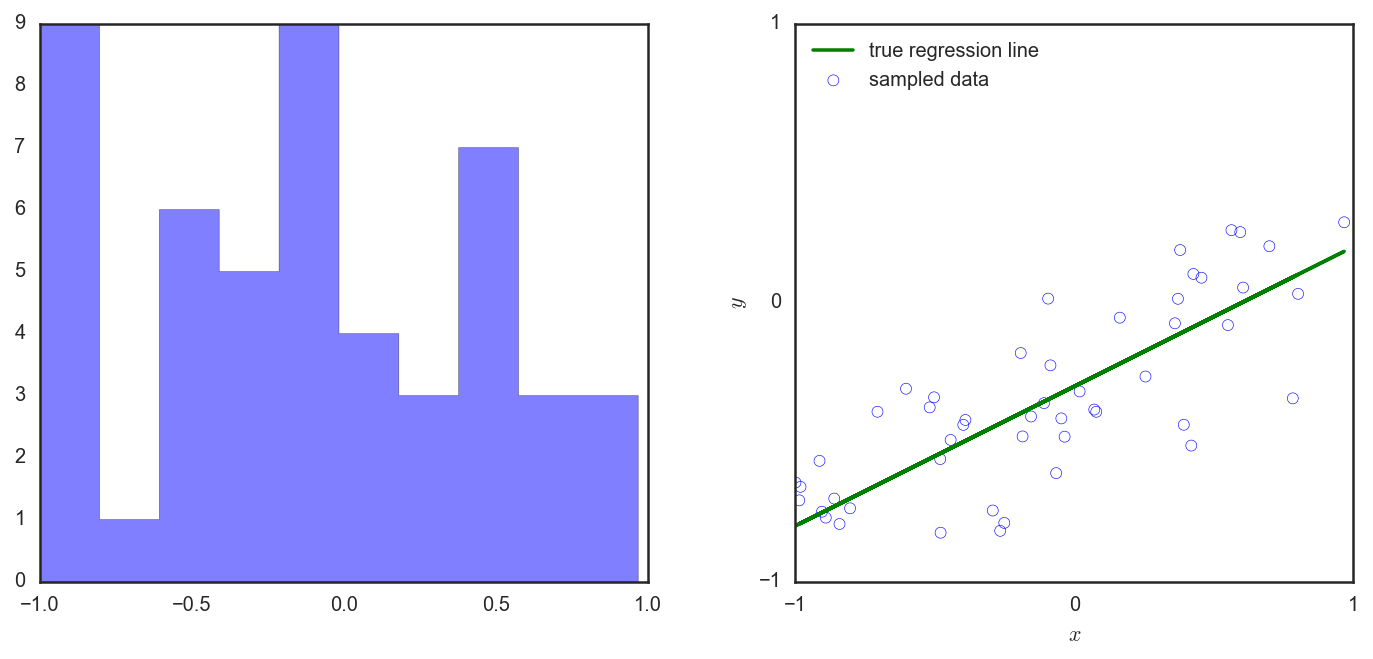

In [27]:
x = stats.uniform.rvs(-1, scale=2, size=size)
y_true = a[0] + a[1] * x 

t_n =  y_true + np.random.normal(scale=sd, size=size)

# plot the generated data
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12,5))

# Left plot - histogram on x 
ax1.hist(x, histtype='stepfilled', alpha=0.5, color='b')

# Right plot
ax2.scatter(x, t_n, s=30, marker='o', facecolors='None', edgecolors='b', label='sampled data')
ax2.plot(x, y_true, c='g', label='true regression line')
ax2.set(xlabel='$x$', ylabel='$y$', xlim=(-1,1), ylim=(-1,1), aspect='equal')
ax2.xaxis.set_ticks([-1,0,1])
ax2.yaxis.set_ticks([-1,0,1])
ax2.legend(loc=2);

### Isotropic Gaussian prior
### $$p(w\,|\,\alpha)= \mathcal{N}(w\,|\,0,\alpha^{-1}I)$$

In [28]:
def calc_init_prior(mean=[0,0], alpha=2.):
    rv = stats.multivariate_normal(mean=mean, cov=alpha**-1*np.identity(2))
   
    return(rv)

In [29]:
def calc_datapoint_likelihood(datapoint=0):
    Z = []
    
    # Calculate the probability for a datapoint on the grid 
    for w0, w1 in grid:
        y = w0 + w1*x[datapoint]
        Z.append(np.sum(stats.norm.pdf(y, loc=t_n[datapoint], scale=sd)))
    
    return(Z)

### Gaussian posterior



### $$p(w\,|\,t) = \mathcal{N}(w\,|\,m_{N}, S_N)$$
### $$m_N = \beta\, S_N\Phi^Tt$$
### $$S_{N}^{-1} = \alpha\,I + \beta\, \Phi^T\Phi$$

In [30]:
def calc_posterior(t, X):
    
    Sn = np.linalg.inv(alpha*np.identity(2) + beta*X.T.dot(X))
    
    mn = beta*Sn.dot(X.T).dot(t)
        
    rv = stats.multivariate_normal(mn.ravel(), cov=Sn)
    
    return(rv)    

In [31]:
def plot_posterior_update(i=1):

    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15,5))

    # Left plot
    Z2 = calc_datapoint_likelihood(i)
    ax1.contourf(xx, yy, np.asarray(Z2).reshape(step,step), cmap=plt.cm.jet)
    ax1.set(title='likelihood', xlabel='$w_0$', ylabel='$w_1$')
    ax1.scatter(*a, s=80, c='w', marker='+', lw=2)

    # Middle plot
    X = np.c_[np.ones(i), x[:i]]
    t = t_n[:i]
    post = calc_posterior(t, X)
    ax2.contourf(xx, yy, post.pdf(grid).reshape(step,step), cmap=plt.cm.jet)
    ax2.scatter(*a, s=80, c='w', marker='+', lw=2)
    ax2.set(title='Posterior')

    # Right plot
    # Draw 6 samples from the posterior and calculate y
    w = post.rvs(6)
    y = w[:,0] + w[:,1]*x_
    ax3.plot(np.tile(x_,(1,6)), y, c='r' , alpha=0.5, linewidth=3)
    ax3.scatter(x[:i], t_n[:i],s=30, marker='o', facecolors='None', edgecolors='b', label='sampled data')

    ax3.set(title='data space', xlabel='$x$', ylabel='$y$')
    ax3.legend(loc=2);

    for ax in fig.axes:
        ax.set(xlim=(-1,1), ylim=(-1,1), aspect='equal')
        ax.xaxis.set_ticks([-1,0,1])
        ax.yaxis.set_ticks([-1,0,1])
    
    return(fig)

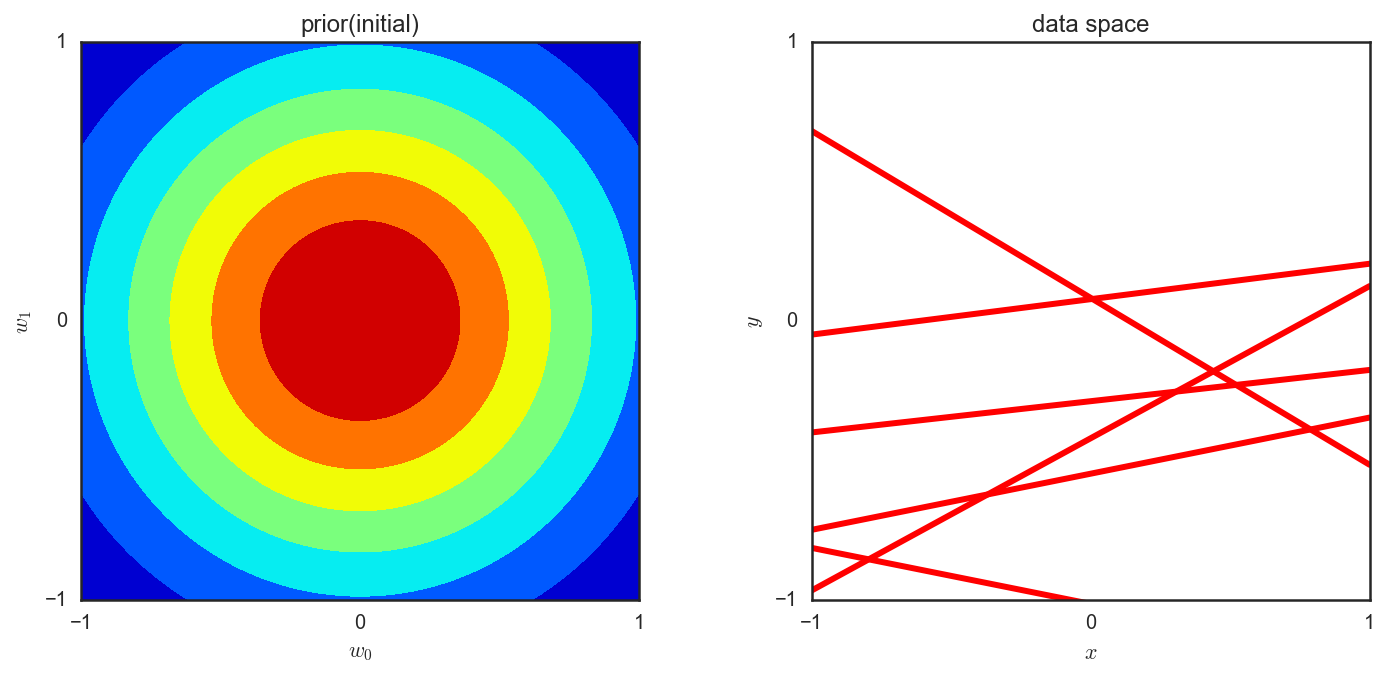

In [32]:
p_prior = calc_init_prior()

# Values for contourplot
Z = p_prior.pdf(grid)

# Draw 6 samples from the prior and calculate y
w = p_prior.rvs(6)
y = w[:,0] + w[:,1]*x_

# Plots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,5))

# Left plot
c = ax1.contourf(xx, yy, Z.reshape(step,step), cmap=plt.cm.jet)
ax1.set(title='prior(initial)', xlabel='$w_0$', ylabel='$w_1$')

# Right plot
ax2.plot(np.tile(x_,(1,6)), y, c='r', linewidth=3)
ax2.set(title='data space', xlabel='$x$', ylabel='$y$')

for ax in fig.axes:
    ax.set(xlim=(-1,1), ylim=(-1,1), aspect='equal')
    ax.xaxis.set_ticks([-1,0,1])
    ax.yaxis.set_ticks([-1,0,1])

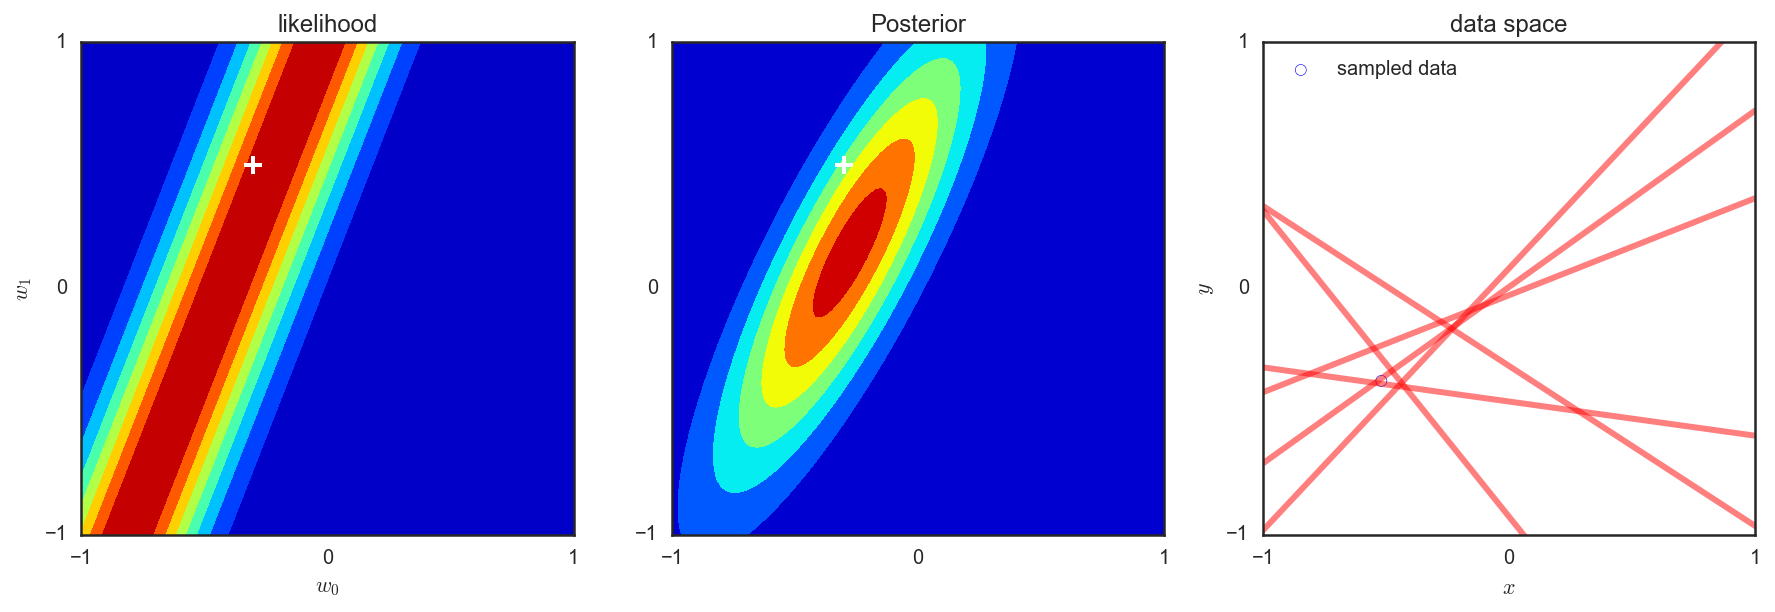

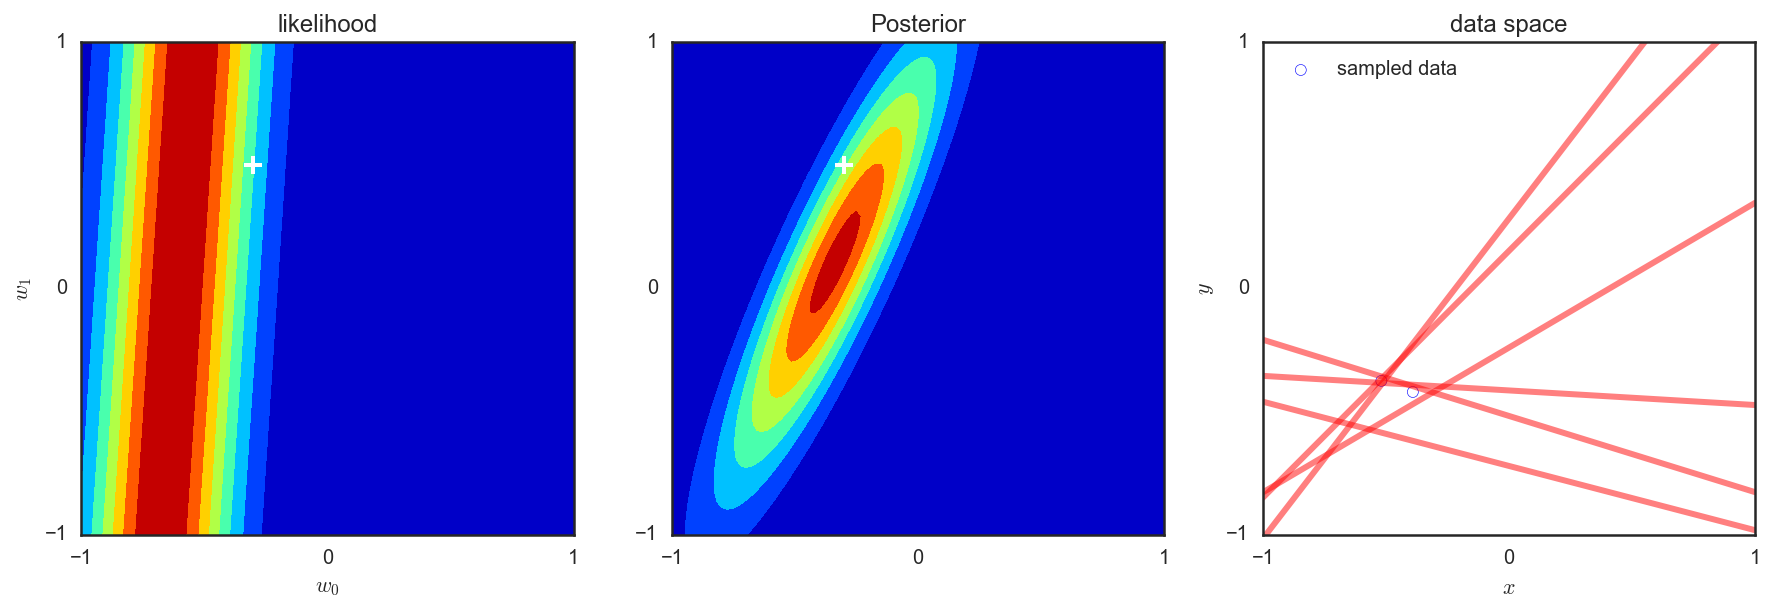

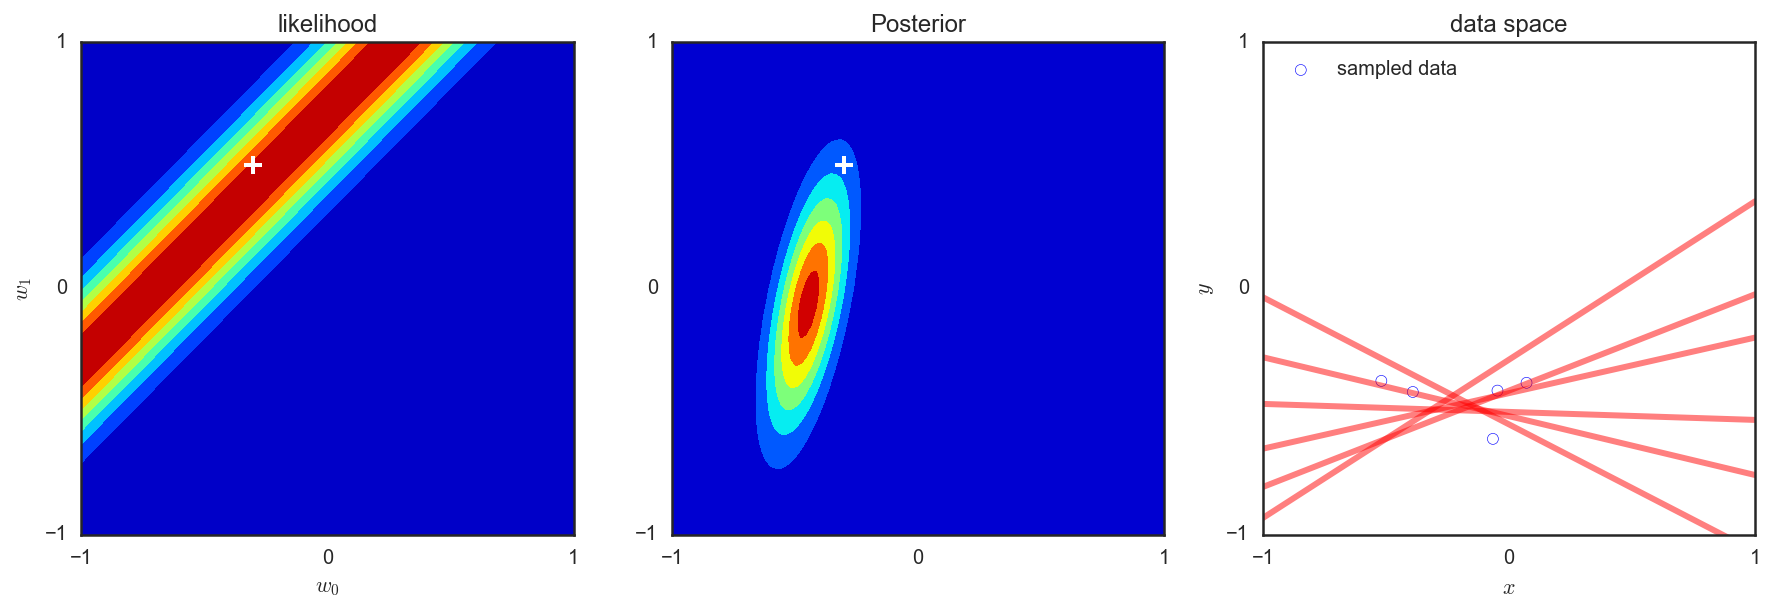

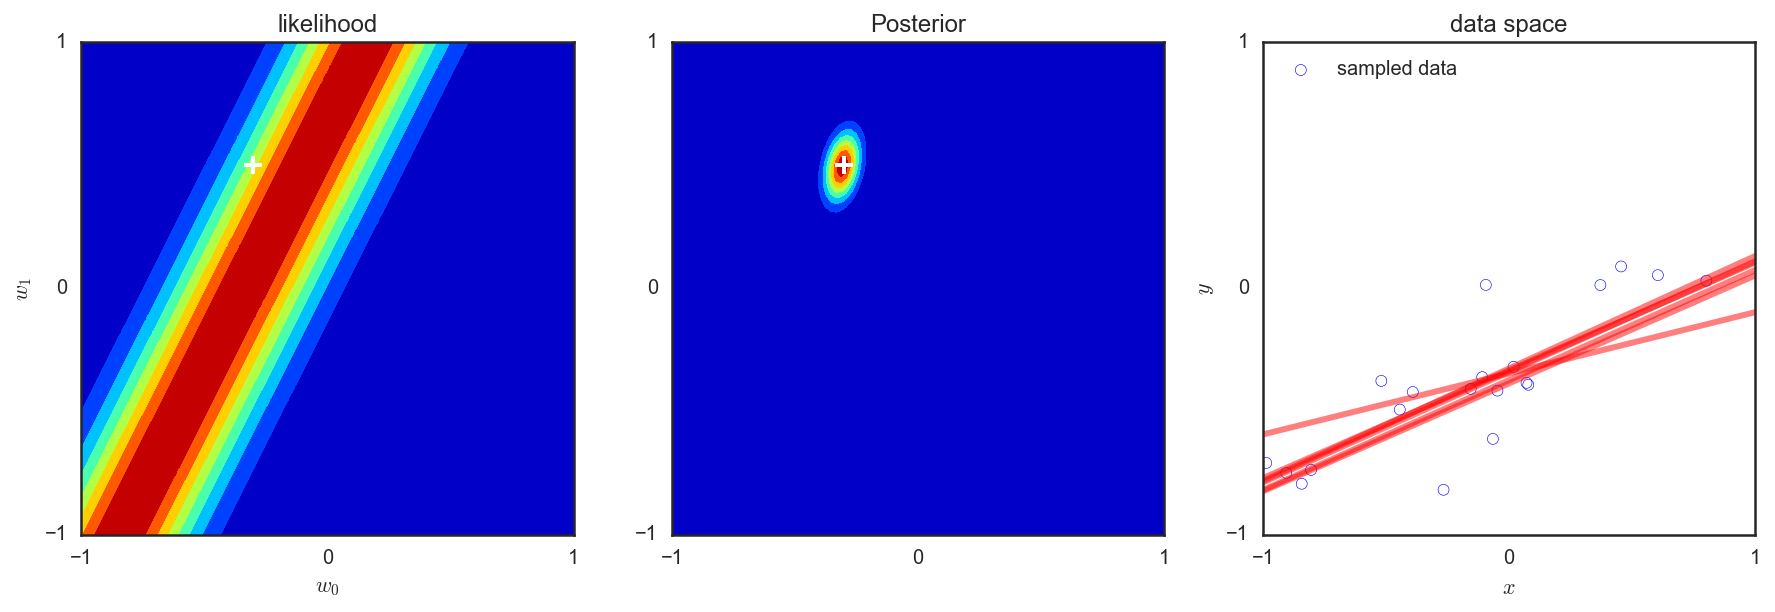

In [36]:
[plot_posterior_update(i) for i in [1, 2, 5, 20]];

### MCMC sampling
Let's see what results we get when we use sampling instead of calculating the posterior analytically.

In [47]:
data = pd.DataFrame({'x':x, 'y':t_n})

with pmc.Model() as model:
    
    pmc.glm.glm('y ~ x', data)
    
    trace = pmc.sample(2000, progressbar=True)

Applied log-transform to sd and added transformed sd_log_ to model.
Assigned NUTS to Intercept
Assigned NUTS to x
Assigned NUTS to sd_log_
 [-----------------100%-----------------] 2000 of 2000 complete in 1.4 sec

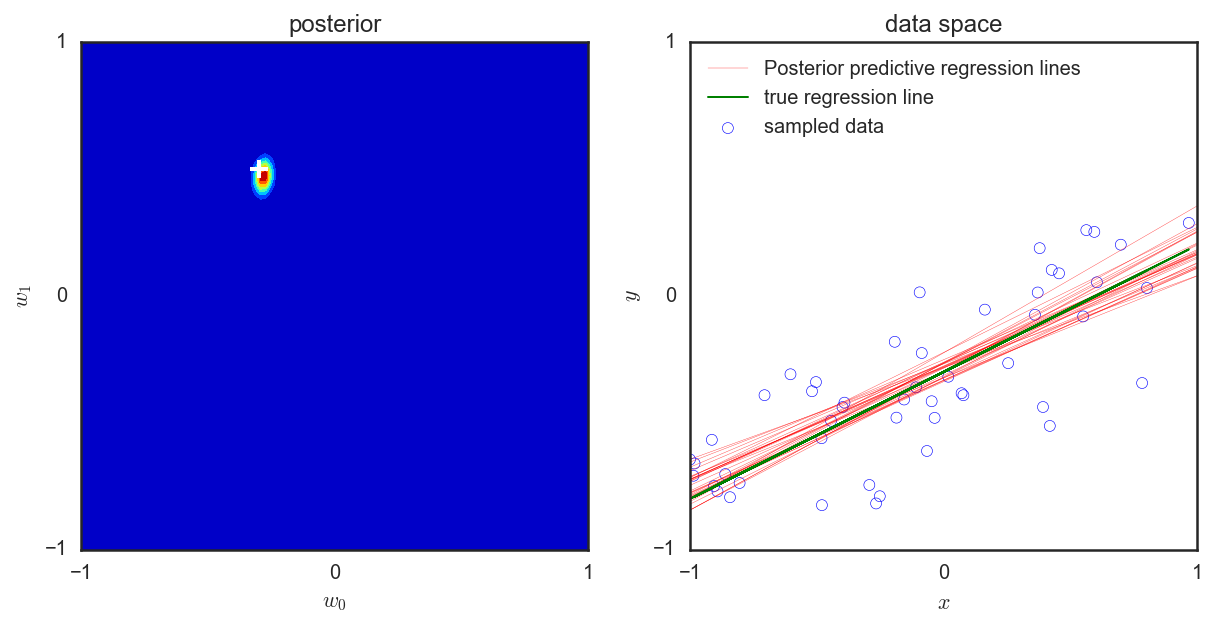

In [48]:
cov = pmc.trace_cov(trace, vars=['Intercept', 'x'])

rv = stats.multivariate_normal(mean=[trace.point(-1)['Intercept'], trace.point(-1)['x']], cov=alpha**-1*cov)
Z = rv.pdf(grid)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,8))

# Left plot
ax1.contourf(xx, yy, Z.reshape(100,100), cmap=plt.cm.jet)
ax1.scatter(-.3, .5, s=80, c='w', marker='+', lw=2)
ax1.set(title='posterior', xlabel='$w_0$', ylabel='$w_1$')

# Right plot
ax2.scatter(data.iloc[:,0], data.iloc[:,1], s=30, marker='o', facecolors='None', edgecolors='b',
            label='sampled data')
pmc.glm.plot_posterior_predictive(trace, samples=30, eval=np.asarray([-1,1]), alpha=0.8, c='r',
                                  label='Posterior predictive regression lines')
ax2.plot(x, y_true, c='g', label='true regression line', lw=1)
ax2.set(title='data space', xlabel='$x$', ylabel='$y$', xlim=(-1,1), ylim=(-1,1))
ax2.legend(loc=2)

for ax in fig.axes:
    ax.set(xlim=(-1,1), ylim=(-1,1), aspect='equal')
    ax.xaxis.set_ticks([-1,0,1])
    ax.yaxis.set_ticks([-1,0,1])